# MBTI Project

By The Introverts 

Our Workflow:
----
- Visualization
- Data Preprocessing
- Feature Engineering
- Modeling
- Evaluation on ROC plot
- Prediction for Celebrity's type

In [ ]:
reset -fs

In [ ]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import string 
import re
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from helperfunctions.PrettyConfusionMatrix import print_cm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import time
import warnings
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')
from random import choice
import lightgbm as lgb
import gc
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
mbti = pd.read_csv('data/mbti_1.csv') 

## Visualization:
#### Personality Types:

First, we take a look at distribution of the MBTI personality types

In [ ]:
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

4 capitals' meaning:
- extroversion vs. introversion 
- intuition vs. sensing
- thinking vs. feeling
- judging vs. perceiving

In [ ]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

In [ ]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

#### Their last 50 posts:
Focus on some statistics(mean,variance) of posts

words they averagely used in per comment

In [ ]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [ ]:
mbti.head()

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='avg_comment_length', data=mbti)

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='comment_length_var', data=mbti)

## Data preprocessing

### Define a function for cleaning the posts:
- Remove "|||" and links and punctuations and MBTI words(As u see in the text, real names user referring to are changed to MBTI type)
- Lowercase
- Lemmatize word, remove stop words and words less than 3 characters (lemmatizing would be better than stemming but takes more time)

In [ ]:
# get 16 types of personality list for removing MBTI words in the following function
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]

In [ ]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # or use PorterStemmer(), if want to run faster
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

In [ ]:
# Here it takes 15mins to run
#processed_post = post_preprocess(mbti)

In [ ]:
# for saving time, load the clean post we have done
processed_post = pd.read_csv('data/mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

### Getting our target

In [ ]:
# A type consists of 4 capitals and each capital corresponds to 2 possible characteristics.
# For later encoding and modeling issues, let's tranfer them into separate binary code.
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
# transfer column 3-6 into binary code.
def type_preprocess(df):
    for i in range(2,6):
        df.iloc[:,i] = df.iloc[:,i].map(type_map)
    return df

In [ ]:
mbti = type_preprocess(mbti)

In [ ]:
mbti.head()

## Feature Engineering

###  Vectorizing Posts 

Create a bag of words representation of each user by using tfidf

In [ ]:
# TfidfVectorizer, those parameters are the  best for model performance.
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.85, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(processed_post['processed_posts'])
word_tfidf = vectorizer_tfidf.transform(processed_post['processed_posts'])
word_tfidf_df = pd.DataFrame(data = word_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names())
# CountVectorizer
vectorizer_ct = CountVectorizer(stop_words='english',analyzer='word',input='content', 
                                 decode_error='ignore', max_df=0.48,min_df=5,
                                 token_pattern=r'\w{1,}', max_features=1625, ngram_range=(1,2)) # to compare two methods, I limit max_features=1625
vectorizer_ct.fit(processed_post['processed_posts'])
word_ct = vectorizer_ct.transform(processed_post['processed_posts'])
word_ct_df = pd.DataFrame(data = word_ct.toarray(), columns = vectorizer_ct.get_feature_names())

In [ ]:
word_tfidf_df.head()

In [ ]:
word_ct_df.head()

### Manual Features

#### Sentiment Score 

**Caution:** Takes a few minutes to run

In [ ]:
# Sentiment Score of clean post
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post['processed_posts'][i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

In [ ]:
mbti['Sentiment'] = scores

#### Ellipses count

Counting number of ellipsies used per user.

In [ ]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in mbti['posts']]
# Append to dataset 
mbti['Ellipses'] = ellipses_count

#### Exclamation count
Counting number of exclamation marks used per user. 

In [ ]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Exclamation'] = exclamation_count

#### Question count
Counting number of question marks used per user. 

In [ ]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Question'] = question_count

#### Link count
Counting number of links used per user. 

In [ ]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to dataframe
mbti['Links'] = link_count

#### Picture count

In [ ]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Picture'] = question_count

#### Emojies count
We should probably modify the text_style_emojies to include more.

In [ ]:
def find_emoji(text):
    # REMOVE LATER ON
    text = text.lower()
    
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [ ]:
mbti['Emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

#### Upper case count

In [ ]:
def del_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    return regex.sub("", text)

In [ ]:
temp = mbti['posts'].apply(lambda x: del_punct(x))
mbti['Upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [ ]:
mbti.head()

#### Additional Cleaning
- Naive Bayes doesn't take negative numbers.
- Sentiment Scores have NaNs

In [ ]:
# NaNs were found: 
mbti.fillna(value=0, inplace=True)
# Naive Bayes can't handle negatives? Scale with MinMax 
min_max_scaler = MinMaxScaler()
sentiment_scaled = min_max_scaler.fit_transform(np.array(mbti['Sentiment']).reshape(-1, 1))
mbti['Sentiment'] = sentiment_scaled

## Model

### Base Model: Multinomial NB & Logistic Regression

In [ ]:
# for saving time, load the data we have done in terms of feature engineering.
mbti = pd.read_csv("data/mbti_FE.csv")
mbti.head()

Here we set a function to collect models' performances on roc

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, cmap=cmap) # interpolation changes the blurriness of the squares 
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(b='False')

    fmt = 'd'
    thresh = cm.max() / 1.5 # threshold controls font color on opaque tile
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black") # if color is darker, use white 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
def get_plot_data(probabilities):
    '''
    Calculates average ROC and Precision vs Recall curves over n_splits of stratified shuffle splits. 
    Not all thresholds are chosen equally, thus different splits have different array lengths of FPR, TPR,
    precision, and recall. In order to average we need the same array length. We will interpolate tpr values 
    between 0 and 1 in 0.1 increments. This gives an average of a set of *estimated* ROC and Precision vs 
    recall estimates. 

    Function returns a dictionary with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'.  
    Within each class value contains another dictionary with keys 'base_x', 'est_tpr', 'roc_auc',
    'est_pr', and 'auc_pr'. 'base_x' is the range of x values used to interpolate both the TPR and precision. 
    '''
    model_data = defaultdict()
    base_x = np.linspace(0,1,101)
        
    for types in probabilities.keys():
        model_data[types] = {'base_x':base_x, 'est_tpr':np.zeros(101), 'auc_roc':[], 'est_pr':np.zeros(101),
                             'auc_pr':[]} 
        total_splits = len(probabilities[types]) 
        for split in probabilities[types]:
            y_scores = split[0] # split[0] is the model probability of predicting a 1
            y_true = split[1] # split[1] is the true test values for that split
            fpr, tpr, thresholds = roc_curve(y_true,y_scores) # used for interpolation
            precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
            model_data[types]['est_tpr'] += np.interp(base_x, fpr, tpr) # Add est_tpr 
            model_data[types]['est_pr'] += np.interp(base_x, recall[::-1], precision[::-1]) # Add est_precision 
            model_data[types]['auc_roc'].append(auc(fpr, tpr)) # Append AUC 
            model_data[types]['auc_pr'].append(auc(recall, precision)) # Append AUC 
        model_data[types]['est_tpr'] = model_data[types]['est_tpr'] / total_splits # Average TPRs 
        model_data[types]['est_pr'] = model_data[types]['est_pr'] / total_splits # Average TPRs 
        model_data[types]['auc_roc'] = np.mean(model_data[types]['auc_roc']) # Average AUC-ROC
        model_data[types]['auc_pr'] = np.mean(model_data[types]['auc_pr']) # Average PR
        
    return model_data

In [ ]:
def threshold_search(y_true, y_proba):
    '''
    searching a threshold to find the best f1-score
    '''
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
#     search_result = {'threshold': best_threshold, 'f1': best_score} print if u want
    return best_score

In [ ]:
def model(model, X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[(p1,y1),(p2,y2),(p3,p3)...],[(p1,y1),(p2,y2),(p3,y3)...],...]
    '''
    
    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    model_data = defaultdict()

    classes = {'EorI':['Extrovert','Introvert'], 'NorS':['Sensing', 'Intuition'],
             'TorF':['Thinking','Feeling'],'JorP':['Perceiving','Judging']}

    t = time.time()
    for col in target.columns:
        print(f"* {classes[col][0]} vs. {classes[col][1]}")
        y = target[col]
        all_auc = []
        all_accuracies = []
        f_score = []
        model_data[col] = []
        avg_cm = np.zeros(4).reshape(2,2).astype(int)
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test]
            model.fit(X_train, y_train)
            probabilities = model.predict_proba(X_test)
            score = probabilities[:, 1]
            preds = model.predict(X_test)
            model_data[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
            fscore = threshold_search(y_test,score)
            f_score.append(fscore)
            avg_cm += confusion_matrix(y_test, preds,[1,0])
        plt.figure()
        plot_confusion_matrix(avg_cm//nsplits, classes=classes[col])
        plt.show()
        print(f'Average AUC: {np.mean(all_auc):.3f}; Average best fscore: {np.mean(f_score):.3f}')
        print("\n")
    print(f"Time use:{time.time()-t:.3f}s")

    return get_plot_data(model_data)

In [ ]:
# initialize
MNB = MultinomialNB()
LR = LogisticRegression(random_state=0,class_weight='balanced')
target = mbti.iloc[:,2:6]

X_tf = pd.concat([mbti.iloc[:,6:],word_tfidf_df],axis=1)
X_ct = pd.concat([mbti.iloc[:,6:],word_ct_df],axis=1)

In [ ]:
mnb_ct_model = model(MNB, X_ct, target, nsplits=5)

In [ ]:
mnb_tf_model = model(MNB, X_tf, target, nsplits=5)

In [ ]:
lr_tf_model = model(LR, X_tf, target, nsplits=5)

In [ ]:
lr_ct_model = model(LR, X_ct, target, nsplits=5)

Notice the great gap between AUC and accuracy in EorI, IorS, both of which are unbalanced. But we can deal with it in the following models.

### Random Forest

In [ ]:
RF = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=7)

In [ ]:
rf_ct_model = model(RF, X_ct, target, nsplits=4)

In [ ]:
rf_tf_model = model(RF, X_tf, target, nsplits=4)

## Advanced Model: Xgboost & Lightgbm

### Xgboost

In [ ]:
XGB = XGBClassifier(eval_metric='auc')

In [ ]:
xgb_ct_model = model(XGB, X_ct, target, nsplits=5)

In [ ]:
xgb_tf_model = model(XGB, X_tf, target, nsplits=5)

### LightGBM

In [ ]:
LGB = lgb.LGBMClassifier(eval_metric='auc')

In [ ]:
lgb_ct_model = model(LGB, X_ct, target, nsplits=5)

In [ ]:
lgb_tf_model = model(LGB, X_tf, target, nsplits=5)

Lightgbm performs a bit better than xgboost in terms of AUC and Accuracy and saves much more time. Besides, Lightgbm running on tfidf vectors outperforms a little bit. I decide to go further on lightgbm and dataset containing tfidf vectors(X_tf).

### Random Search
- iteration=20 takes nearly 25mins to run

In [ ]:
kf = StratifiedShuffleSplit(n_splits=5, random_state=420)

# loop for random search
n_iterations=20

print ("Random search start...")
for col in target.columns:
    print(f"* {types[col]} ")
    y = target[col]
    roc_auc_mean = []
    dict_list = []
    for i in range(0, n_iterations):

        param_dist = {'n_estimators' : choice([250,300,350,400,450]),
                  'bagging_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                  'learning_rate': choice([0.05, 0.1, 0.3, 0.5]),
                  'is_unbalance': True,
                  'max_bin': choice([3, 5, 10, 15, 18, 20, 25]),
                  'boosting_type' : choice(['gbdt', 'dart']),
                  'max_depth': choice([2,3,4,5]),      
                  'feature_fraction': choice([0.7, 0.8, 0.9]),
                  'lambda_l1': choice([0, 10, 20, 30, 40]),
                  'objective': 'binary', 
                  'metric': 'auc'} 

        roc_l = []

        for train, test in kf.split(X_tf,y):

            X_train, X_test, y_train, y_test = X_tf.loc[train], X_tf.loc[test], y[train], y[test]

            # training
            gbm = lgb.LGBMClassifier(**param_dist)
            gbm.fit(X_train,y_train)
            # predicting
            y_pred = np.round(gbm.predict_proba(X_test)[:,1],3)
            roc = roc_auc_score(y_test, y_pred)
            roc_l.append(roc)

        roc_array = np.asarray(roc_l)

        roc_auc_mean.append(roc_array.mean())
        dict_list.append(param_dist)
        gc.collect()

    results_pd = pd.DataFrame({"roc_auc_mean": roc_auc_mean,"parameters": dict_list})    

    results_pd.sort_values("roc_auc_mean", ascending = False, axis = 0, inplace = True)
    top_pd = results_pd.head(1)
    print(f"--> Best AUC:{top_pd.iloc[0,0]} using {top_pd.iloc[0,1]}")

In [ ]:
def treemodel(X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[p1,p2,p3...],[p1,p2,p3...],...]
    '''

    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    total_probabilities = defaultdict()
#     this is for lgb
    para_list = [{'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}]
    # this is for rf
#     para_list = [{'n_estimators': 1525, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False},
#              {'n_estimators': 575, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False},
#              {'n_estimators': 1525, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False},
#              {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}]
    
    classes = {'EorI':['Extroverts','Introverts'], 'NorS':['Sensing', 'Intuition'],
             'TorF':['Thinking','Feeling'],'JorP':['Perceiving','Judging']}
    
    
    t = time.time()
    for i,col in enumerate(target.columns):
        print(f"* {types[col]} ")
        param = para_list[i]
        
        y = target[col]
        all_auc = []
#         all_accuracies = []
        f_score = []
        total_probabilities[col] = []
        avg_cm = np.zeros(4).reshape(2,2).astype(int)
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test] 
            gbm = lgb.LGBMClassifier(**param)
            gbm.fit(X_train,y_train)
#             rf = RandomForestClassifier(**param)
#             rf.fit(X_train,y_train)
            # predicting
            probabilities = gbm.predict_proba(X_test)
            preds = gbm.predict(X_test)
#             probabilities = rf.predict_proba(X_test)
            score = probabilities[:, 1]
#             preds = model.predict(X_test)
            total_probabilities[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
#             all_accuracies.append(accuracy_score(y_test,preds))
            avg_cm += confusion_matrix(y_test, preds,[1,0])
            fscore = threshold_search(y_test,score)
            f_score.append(fscore)
        plt.figure()
        plot_confusion_matrix(avg_cm//nsplits, classes=classes[col])
        plt.show()
        
        print(f'Average AUC: {np.mean(all_auc):.3f}; Average best fscore: {np.mean(f_score):.3f}')
        print("\n")
    print(f"Time use:{time.time()-t:.3f}s")

    return get_plot_data(total_probabilities)

In [ ]:
lgb_tf_model_t = treemodel(X_tf, target, nsplits=5)

### What about voting model?

In [ ]:
pm =  {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'}

In [ ]:
Lgbm = lgb.LGBMClassifier(**pm)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting_clf = VotingClassifier(estimators = [('lgbm', Lgbm), 
                                            ('xgb', XGB), 
                                            ('mnb',MNB), 
                                            ('lr',LR)],
                              voting = 'soft')

In [ ]:
voting = model(voting_clf, X_tf, target, nsplits=5)

## Evaluation on ROC plot

In [42]:
def auc_plot(model_list, model_names, plot_type):
    '''
    From model list and model names, plots ROC curves for each class on a 2x2 grid.
    Add more colors to colors list if number of model exceeds current list length.
    '''
    fig, axs = plt.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='b')
    axs = axs.flatten()
    abbrev = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                     'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    colors = ['b','g','c','m','y']

    if plot_type == 'roc':
        y_axis = 'est_tpr'
        auc_type = 'auc_roc'
        plot_name = 'ROC'
        legend_position = 'lower right'
        y_label = 'True Positive Rate'
        x_label = 'False Positive Rate'
    elif plot_type =='pr':
        y_axis = 'est_pr'
        auc_type = 'auc_pr'
        plot_name = 'Precision vs Recall'
        legend_position = 'upper right'
        y_label = 'Precision'
        x_label = 'Recall'
    else:
        raise AttributeError('Invalid plot type')

    for x in range(len(model_list)):
        plot_data = model_list[x]
        types = list(plot_data.keys())

        for i in range(len(types)):
            x_axis = plot_data[types[i]]['base_x']
            est_y = plot_data[types[i]][y_axis]
            auc = plot_data[types[i]][auc_type]
            axs[i].plot(x_axis, est_y, colors[x], linewidth=1, label = '%s = %0.2f' %(model_names[x], auc))
            if plot_type == 'roc':
                axs[i].plot([0, 1], [0, 1],'r--', linewidth = 1)
            axs[i].legend(loc = legend_position, title = 'Avg AUC Scores',frameon=False)            
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([0, 1])
            axs[i].set_ylabel(y_label)
            axs[i].set_xlabel(x_label)
            axs[i].set_title(f'{plot_name} for {abbrev[types[i]]}')

In [ ]:
model_list = [lr_tf_model, lgb_tf_model_t, xgb_tf_model,rf_tf_model,voting] # 4 best models
model_names = ['LR TFIDF', 'LGB TFIDF tuned','XGB TFIDF','RF TFIDF','VOTING TFIDF']

In [ ]:
model_list=[lr_ct_model, lr_tf_model, mnb_tf_model, mnb_ct_model]
model_names=['test1','test2','test3','test4']
plot_type='pr'

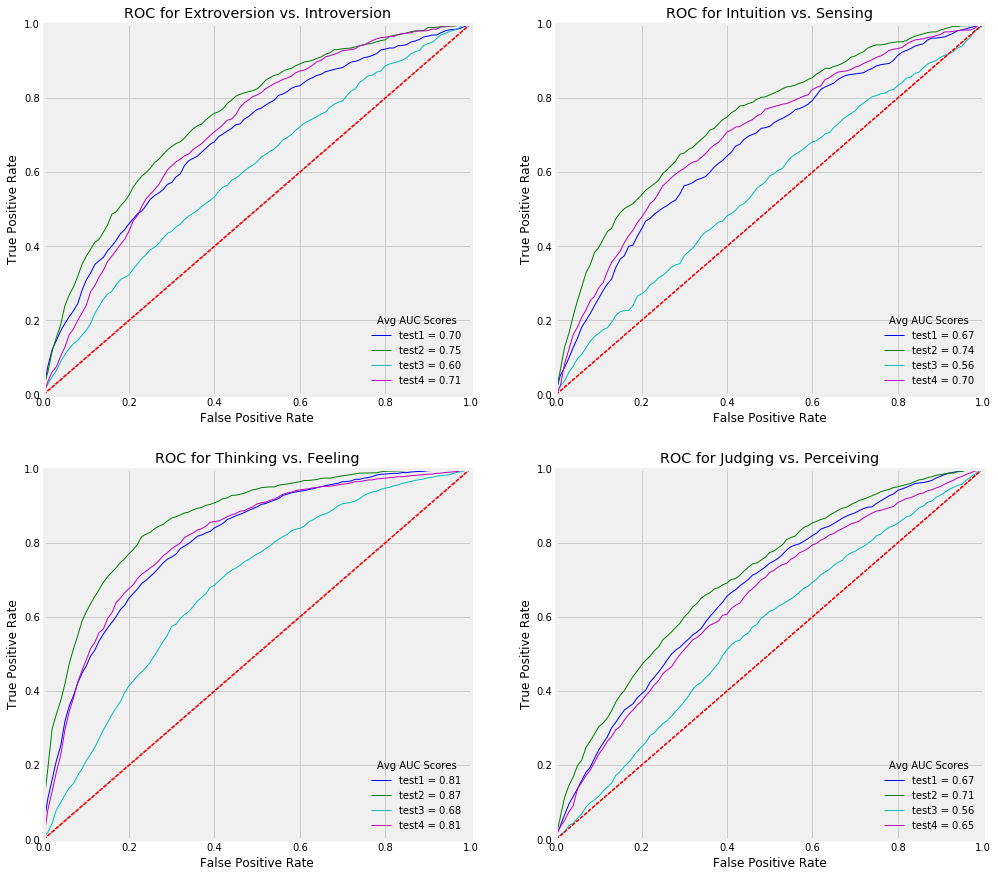

In [44]:
auc_plot(model_list, model_names, plot_type='roc')

In terms of ROC, Logistic regression model performs the best.

## Prediction for celebrities

In [ ]:
cb = pd.read_csv('data/celeb_twitter_mbti.csv')
cb.head()

In [ ]:
cb['EorI']= cb['type'].apply(lambda x:x[0])
cb['NorS']= cb['type'].apply(lambda x:x[1])
cb['TorF']= cb['type'].apply(lambda x:x[2])
cb['JorP']= cb['type'].apply(lambda x:x[3])
cb.head()

In [ ]:
cb['avg_comment_length'] = cb['posts'].apply(lambda x: len(x.split())/50)
cb['comment_length_var'] = cb['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

going on.....

### Additional things to Consider:

- How to explain EorI things to the auidence in an easy way
- add pca
- others....